In [9]:
# 1. 인물모드 직접 해 보기

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.12.0


원본 고양이 이미지 크기: (764, 1000, 3)
배경(사막) 이미지 크기: (666, 1000, 3)


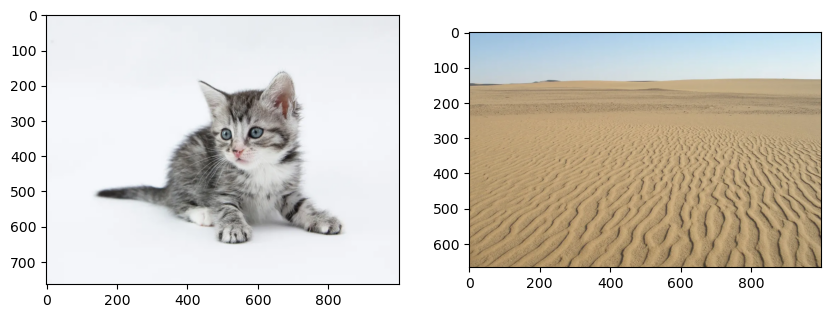

In [10]:
home_dir = os.getenv('HOME')

cat_img_path = os.path.join(home_dir, "work/human_segmentation/images/cat.png")  # 고양이 이미지를 준비해주세요
sand_img_path = os.path.join(home_dir, "work/human_segmentation/images/sand.png")  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [11]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/jovyan/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:03<00:00, 63.0MB/s] 


추론 마스크 크기 (Before Resize): (520, 520)


In [12]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (764, 1000)


In [13]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


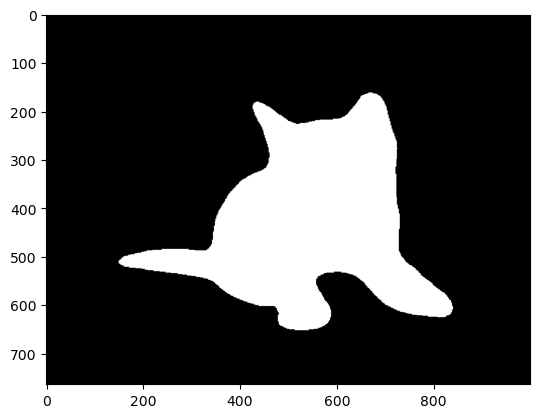

In [14]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

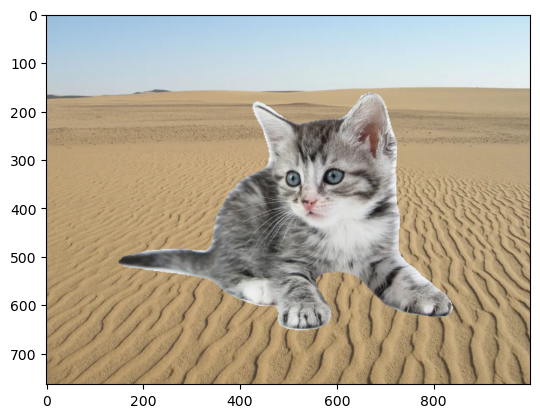

In [15]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

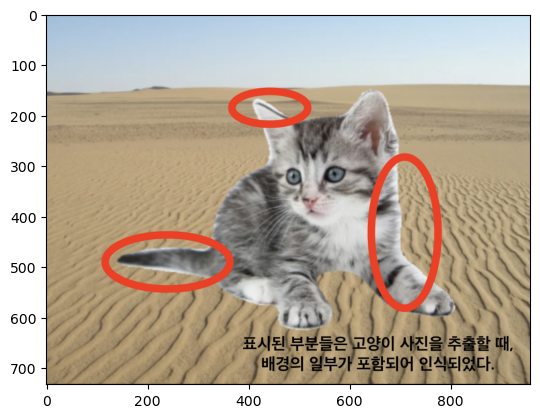

In [21]:
# 2. 사진에서 문제점 찾기

home_dir = os.getenv('HOME')
matter = os.path.join(home_dir, "work/human_segmentation/images/matter.png")

matter = cv2.imread(matter)
matter = cv2.cvtColor(matter, cv2.COLOR_BGR2RGB)

plt.imshow(matter)
plt.show()

In [ ]:
# 3. 해결 방법을 제안해 보기

'''
### Edge-Aware Refinement + Depth Estimation Fusion ###

1. Edge-Aware Refinement(경계선 보전)
→ segmentation이 만든 mask의 경계를 더 부드럽고 정확하게 만들어준다

    CRF
    - 주변 픽셀 간의 관계를 고려해 mask를 보정
    - ex) 머리카락처럼 경계가 흐릿한 곳도 선명하게 인식

    Edge-aware란
    - 이미지의 실제 밝기/색상 변화(edge)를 고려해서 마스크 경계를 보정

2. Depth Estimation (MiDaS 등)
→ 단일 이미지로부터 각 픽셀이 어느 정도의 거리(깊이)에 있는지를 예측한다

    필요 목적
    - 실제 카메라 렌즈는 거리가 먼 것일수록 흐릿하게 보임
    - 사람이 가까울수록 선명하고, 멀수록 보케 효과가 들어가야 자연스러움

    방법론
    - 사람 마스크와 depth map을 합침
        - 얼굴(가깝다) → 선명하게
        - 어깨나 등(멀다) → 살짝 흐리게



## 기술 구성 ##

1. Edge-aware CRF (Conditional Random Field) → 경계 정제
 - DeepLab이 만든 mask에 대해 이미지의 경계선(edge)을 고려한 CRF 후처리를 수행하여 인물/배경 경계를 정밀화 

2. Monocular Depth Estimation 모델 (e.g., MiDaS) → 심도 추정
 - 단일 이미지로부터 각 픽셀의 상대적인 depth 값을 예측

3. Mask-Depth Fusion Algorithm → 포커싱 정교화
 - segmentation mask와 depth map을 결합해, 인물 내에서도 가까운 부위는 선명하게, 먼 부위는 살짝 흐림 처리
 
4. Soft Boundary Blending → 자연스러운 보케 효과
 - 마스크 경계에 `Gaussian blur`나 `alpha blending` 적용해 경계가 날카롭게 잘리지 않도록 보정



## 동작 메커니즘 ##

[입력 이미지]
     ↓
[Semantic Segmentation (DeepLab)]
     ↓
[CRF 후처리 → 경계 보정된 mask]
     ↓
[Monocular Depth Estimation (MiDaS)]
     ↓
[인물 마스크 & Depth Map Fusion]
     ↓
[Soft Focus Map 생성 (depth 기반 가중 보케)]
     ↓
[최종 인물 모드 렌더링 (배경 블러)]



## 사용 예시 ##

- 머리카락 주변이 자연스럽게 표현됨 (CRF)
- 얼굴은 선명하지만 어깨 쪽으로 갈수록 부드러운 보케 (depth 기반)
- 손가락 사이 공간 같은 세밀한 구조도 정확히 표현

'''